# Correclation Matrix

In [160]:
import xarray as xr
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sea
import numpy as np 

In [161]:
file_path_foc = '/lustre/storeB/project/fou/hi/foccus'
file_path_ml = '/experiments/ngpus-2017-24/inference/lam-48h-step_002016.nc' 
file_path_nor_02 = '/datasets/symlinks/norkystv3-hindcast/2024/norkyst800-20240402.nc'
file_path_nor_03 = '/datasets/symlinks/norkystv3-hindcast/2024/norkyst800-20240403.nc'

In [162]:
ds_ml = xr.open_dataset(file_path_foc + file_path_ml).sel(time = slice('2024-04-02T00:00:00.000000000','2024-04-02T21:00:00.000000000')) #limiting the inference to the 2nd of April
ds_norkyst_02 = xr.open_dataset(file_path_foc + file_path_nor_02).isel(s_rho = -1) #starting with just importing the 2nd of April
ds_ml.data_vars.keys()

KeysView(Data variables:
    latitude           (values) float32 12MB ...
    longitude          (values) float32 12MB ...
    h                  (time, values) float32 98MB ...
    salinity_0         (time, values) float32 98MB ...
    sea_mask           (time, values) float32 98MB ...
    temperature_0      (time, values) float32 98MB ...
    u_eastward_0       (time, values) float32 98MB ...
    v_northward_0      (time, values) float32 98MB ...
    zeta               (time, values) float32 98MB ...
    Pair               (time, values) float32 98MB ...
    Qair               (time, values) float32 98MB ...
    Tair               (time, values) float32 98MB ...
    Uwind              (time, values) float32 98MB ...
    Vwind              (time, values) float32 98MB ...
    cloud              (time, values) float32 98MB ...
    cos_julian_day     (time, values) float32 98MB ...
    cos_latitude       (time, values) float32 98MB ...
    cos_local_time     (time, values) float32 98MB .

In [163]:
#Will convert the dataset to a pandas one to use the correlation matrix function, but first remove the unnessecary vars from the dataset
def remove_vars(dataset, vars_to_keep):
    vars_keep = list(vars_to_keep)
    vars = list(dataset.data_vars.keys())
    diff = list(filter(lambda i: i not in vars_keep, vars)) #filtering out the variables from vars keep and removing them from vars
    dataset = dataset.drop_vars(diff)
    print(f"All other variables removed. The variables dropped are: {diff}")
    return dataset


In [164]:
ds_ml_speeds_temp = remove_vars(ds_ml, ["temperature_0", "salinity_0", "Uwind", "Vwind", "u_eastward_0", "v_northward_0"])
ds_ml_speeds_temp.head()

All other variables removed. The variables dropped are: ['latitude', 'longitude', 'h', 'sea_mask', 'zeta', 'Pair', 'Qair', 'Tair', 'cloud', 'cos_julian_day', 'cos_latitude', 'cos_local_time', 'cos_longitude', 'f', 'insolation', 'rain', 'river_binary_mask', 'sin_julian_day', 'sin_latitude', 'sin_local_time', 'sin_longitude']


<xarray.Dataset> Size: 640B
Dimensions:        (time: 5, values: 5)
Coordinates:
  * time           (time) datetime64[ns] 40B 2024-04-02 ... 2024-04-02T12:00:00
Dimensions without coordinates: values
Data variables:
    salinity_0     (time, values) float32 100B ...
    temperature_0  (time, values) float32 100B ...
    u_eastward_0   (time, values) float32 100B ...
    v_northward_0  (time, values) float32 100B ...
    Uwind          (time, values) float32 100B ...
    Vwind          (time, values) float32 100B ...

In [165]:
#converting to pandas for use of the pandas correlation matrix
ds_ml_pd = ds_ml_speeds_temp.to_dataframe()
ds_ml_pd.head()

salinity_0  temperature_0  u_eastward_0  v_northward_0  \
time       values                                                           
2024-04-02 0              NaN            NaN           0.0            0.0   
           1              NaN            NaN           0.0            0.0   
           2              NaN            NaN           0.0            0.0   
           3              NaN            NaN           0.0            0.0   
           4              NaN            NaN           0.0            0.0   

                       Uwind     Vwind  
time       values                       
2024-04-02 0        9.909610 -1.139936  
           1        9.993424 -1.149863  
           2       10.077207 -1.159782  
           3       10.142060 -1.169703  
           4       10.199883 -1.179619

In [166]:
#Calculating the correlation matrix using pandas 
corr_matrix = ds_ml_pd.corr()

Text(0.5, 1.0, 'Correlation Matrix Ngpus 2024-04-02')

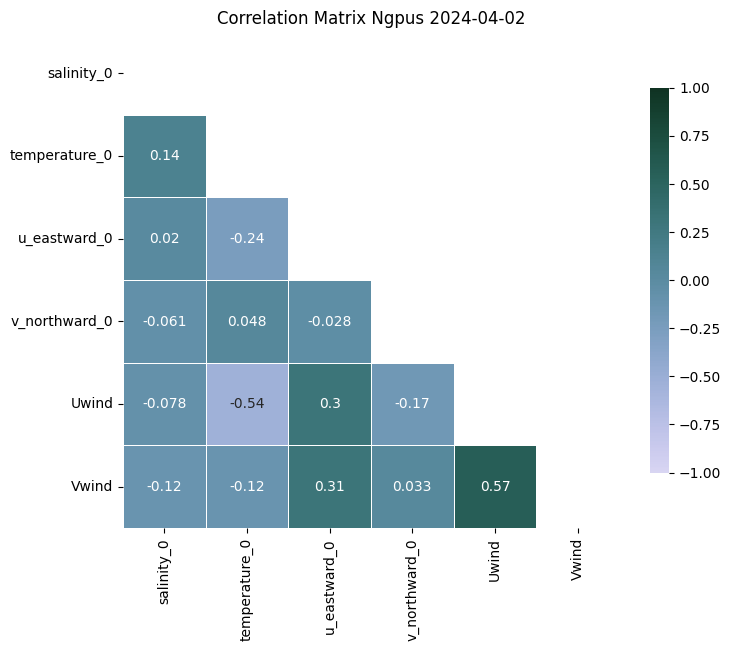

In [167]:
#plot the correlation matrix on the diagonal
#inspiration from https://seaborn.pydata.org/examples/many_pairwise_correlations.html 

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(8,10))
cmap = sea.cubehelix_palette(230,20, as_cmap = True)
sea.heatmap(corr_matrix, mask = mask, cmap = cmap, vmax = 1, vmin=-1, center = 0, square = True, linewidths = 0.5, cbar_kws={'shrink': 0.5}, annot = True)
plt.title("Correlation Matrix Ngpus 2024-04-02")

In [168]:
#Thought it might be nice to make one for the pressure, clouds, rain etc.
ds_ml_fluxes = remove_vars(ds_ml, ['salinity_0', 'temperature_0', 'Pair', 'Qair', 'Tair', 'cloud', 'rain'])

All other variables removed. The variables dropped are: ['latitude', 'longitude', 'h', 'sea_mask', 'u_eastward_0', 'v_northward_0', 'zeta', 'Uwind', 'Vwind', 'cos_julian_day', 'cos_latitude', 'cos_local_time', 'cos_longitude', 'f', 'insolation', 'river_binary_mask', 'sin_julian_day', 'sin_latitude', 'sin_local_time', 'sin_longitude']


Text(0.5, 1.0, 'Correlation Matrix Ngpus 2024-04-02')

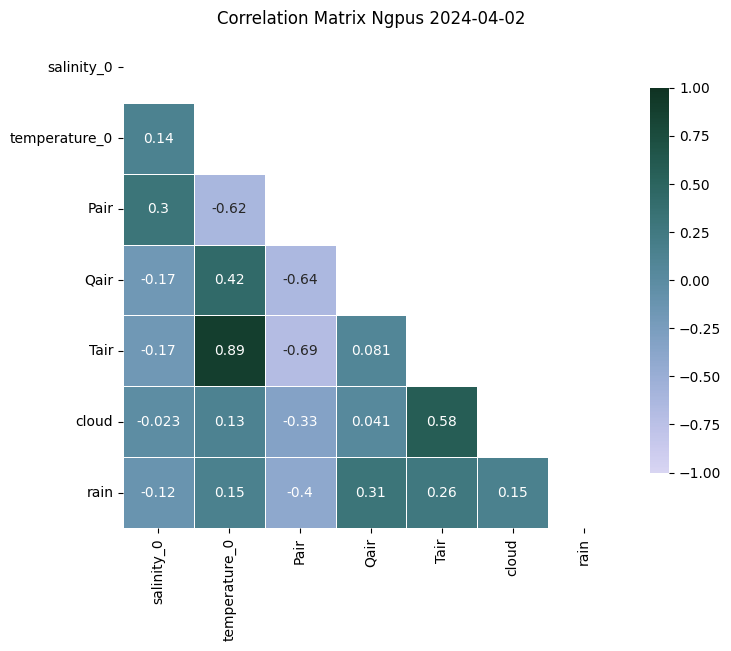

In [172]:
ds_ml_pd_fluxes = ds_ml_fluxes.to_dataframe()
corr_matrix_fluxes = ds_ml_pd_fluxes.corr()

mask = np.triu(np.ones_like(corr_matrix_fluxes, dtype=bool))
fig, ax = plt.subplots(figsize=(8,10))
cmap = sea.cubehelix_palette(230,20, as_cmap = True)
sea.heatmap(corr_matrix_fluxes, mask = mask, cmap = cmap, vmax = 1, vmin=-1, center = 0, square = True, linewidths = 0.5, cbar_kws={'shrink': 0.5}, annot = True)
plt.title("Correlation Matrix Ngpus 2024-04-02")